In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import pickle
import itertools
from PIL import Image, ImageOps
import matplotlib.pyplot as plt

import tensorflow as tf
import keras
from keras import regularizers
from tensorflow.keras import initializers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.applications import VGG16
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from sklearn.metrics import accuracy_score, multilabel_confusion_matrix, precision_score, recall_score, f1_score

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

In [ ]:
# Read the metadata.csv file into a pandas DataFrame
# path = '/content/drive/My Drive/DukeStudies/548L_MLI_Project/Skin_Lesion_Classification/HAM10000data/'
# path = '/content/drive/MyDrive/Sp23/BME548L_Machine_Learning_and_Imaging/548L_MLI_Project/Skin_Lesion_Classification/HAM10000data/'
path = '/content/drive/MyDrive/Sp23/BME548L_Machine_Learning_and_Imaging/548L_MLI_Project/Git_Repo/'

#Data Loading

In [ ]:
# Load the data
with open(path + 'augmented_datas.pickle', 'rb') as f:
    data = pickle.load(f)

# Separate the images and labels
X = data['X']
y = data['y']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Split the training set into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

# Convert string labels to integer labels
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)
y_val = label_encoder.transform(y_val)

# Convert integer labels to one-hot encoded arrays
num_classes = len(label_encoder.classes_)
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)
y_val = to_categorical(y_val, num_classes)

# Print the shape of the data
print('Training data shape:', X_train.shape)
print('Training labels shape:', y_train.shape)
print('Validation data shape:', X_val.shape)
print('Validation labels shape:', y_val.shape)
print('Test data shape:', X_test.shape)
print('Test labels shape:', y_test.shape)

Training data shape: (2016, 128, 128, 3)
Training labels shape: (2016, 7)
Validation data shape: (224, 128, 128, 3)
Validation labels shape: (224, 7)
Test data shape: (560, 128, 128, 3)
Test labels shape: (560, 7)


In [ ]:
print(label_encoder.classes_)

['akiec' 'bcc' 'bkl' 'df' 'mel' 'nv' 'vasc']


(-0.5, 127.5, 127.5, -0.5)

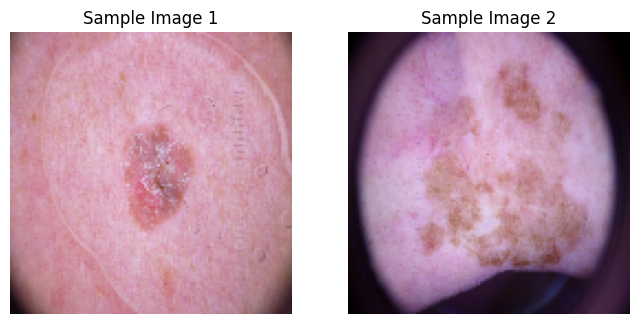

In [ ]:
sample_image1 = X_train[40]
sample_image2 = X_train[1]
fig, ax = plt.subplots(1, 2, figsize=(8, 8))
ax[0].imshow(cv2.cvtColor(sample_image1, cv2.COLOR_BGR2RGB))
ax[0].set_title("Sample Image 1")
ax[0].axis('off')
ax[1].imshow(cv2.cvtColor(sample_image2, cv2.COLOR_BGR2RGB))
ax[1].set_title("Sample Image 2")
ax[1].axis('off')

#Training with Base Model

In [ ]:
# Define a base model
image_size = (128, 128, 3)

# # Load the VGG16 model with imagenet weights
# base_model = VGG16(weights='imagenet', include_top=False, input_shape=image_size)
# base_model.trainable = False

# # Load the ResNet152 model with imagenet weights
# base_model = tf.keras.applications.ResNet152(
#     include_top=False, weights='imagenet', input_shape=image_size)
# base_model.trainable = False

# Load the InceptionV3 model with imagenet weights
base_model = tf.keras.applications.InceptionV3(
    include_top=False, weights='imagenet',pooling='avg', input_shape=image_size)

87910968/87910968 [==============================] - 3s 0us/step


In [ ]:
# Build the full model with only the base model (InceptionV3)
model = tf.keras.Sequential([
    # Input layer
    tf.keras.layers.Input(image_size),
    
    # batch Normalization layer
    tf.keras.layers.BatchNormalization(),

    base_model,
    Dropout(0.5),
    Dense(128, activation="relu",kernel_regularizer=regularizers.l2(0.02)),
    Dropout(0.5),
    Dense(7, activation = 'softmax',kernel_regularizer=regularizers.l2(0.02))
])

# Compile the model with an Adam optimizer and cross-entropy loss function
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

# Train the model on the training set
hist = model.fit(X_train, y_train, batch_size=20, epochs=35, validation_data=(X_val, y_val))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_94 (Bat  (None, 128, 128, 3)      12        
 chNormalization)                                                
                                                                 
 inception_v3 (Functional)   (None, 2048)              21802784  
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 7)                 903       
                                                        

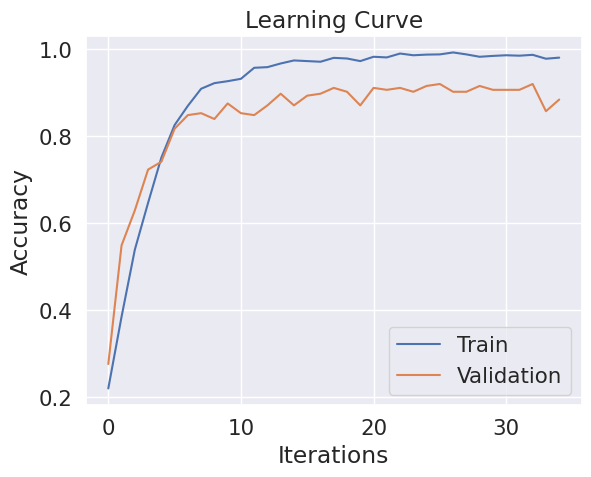

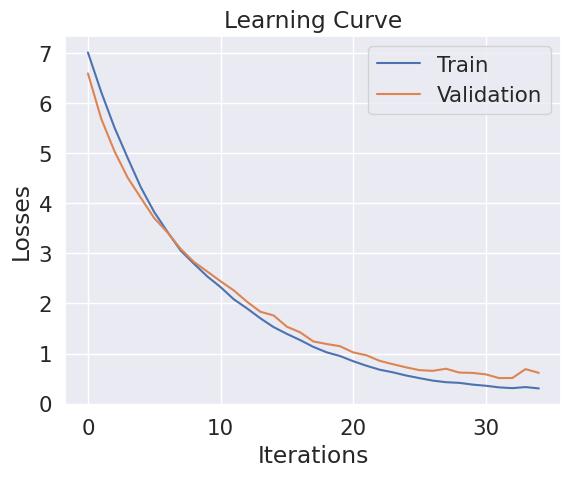

In [ ]:
plt.title("Learning Curve")
plt.plot(np.arange(35),hist.history.get('accuracy'), label="Train")
plt.plot(np.arange(35),hist.history.get('val_accuracy'), label="Validation")
plt.xlabel("Iterations")
plt.ylabel("Accuracy")
plt.legend(loc='best')
plt.show()

plt.title("Learning Curve")
plt.plot(np.arange(35),hist.history.get('loss'), label="Train")
plt.plot(np.arange(35),hist.history.get('val_loss'), label="Validation")
plt.xlabel("Iterations")
plt.ylabel("Losses")
plt.legend(loc='best')
plt.show()

In [ ]:
# Create a function that calls out the confusion matrix
def metrics(X_test,y_test,trained_model):
  from sklearn.metrics import confusion_matrix
  data_labels = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
  train_pred = trained_model.predict(X_train)
  train_pred_classes = np.argmax(train_pred,axis = 1)
  test_pred = trained_model.predict(X_test)
  # Convert predictions classes to one hot vectors 
  test_pred_classes = np.argmax(test_pred,axis = 1) 
  y_lab_c_mat = []
  for lab in y_test:
    y_lab_c_mat.append(np.argmax(lab))
  confusionmatrix = confusion_matrix(y_lab_c_mat, test_pred_classes)
  import seaborn as sns
  #mask = np.diag(np.ones(7))
  plt.figure(figsize=(10,10))
  sns.set(font_scale=1.4)
  sns.heatmap(confusionmatrix, cmap = "viridis", square=True, linewidths=.5, cbar_kws={"shrink": .5},annot=True, xticklabels=data_labels, yticklabels= data_labels,fmt='g')
  from sklearn.metrics import classification_report
  # Generate a classification report
  #trainreport = classification_report(trainlabels, train_pred_classes, target_names=list(labels))
  testreport = classification_report(y_lab_c_mat, test_pred_classes, target_names=data_labels)
  #print(trainreport)
  print(testreport)

18/18 [==============================] - 2s 31ms/step
              precision    recall  f1-score   support

       akiec       0.86      0.93      0.89        73
         bcc       0.82      0.89      0.86        83
         bkl       0.84      0.84      0.84        76
          df       0.97      0.84      0.90        77
         mel       0.88      0.79      0.83        86
          nv       0.87      0.93      0.90        89
        vasc       0.99      0.99      0.99        76

    accuracy                           0.89       560
   macro avg       0.89      0.89      0.89       560
weighted avg       0.89      0.89      0.89       560



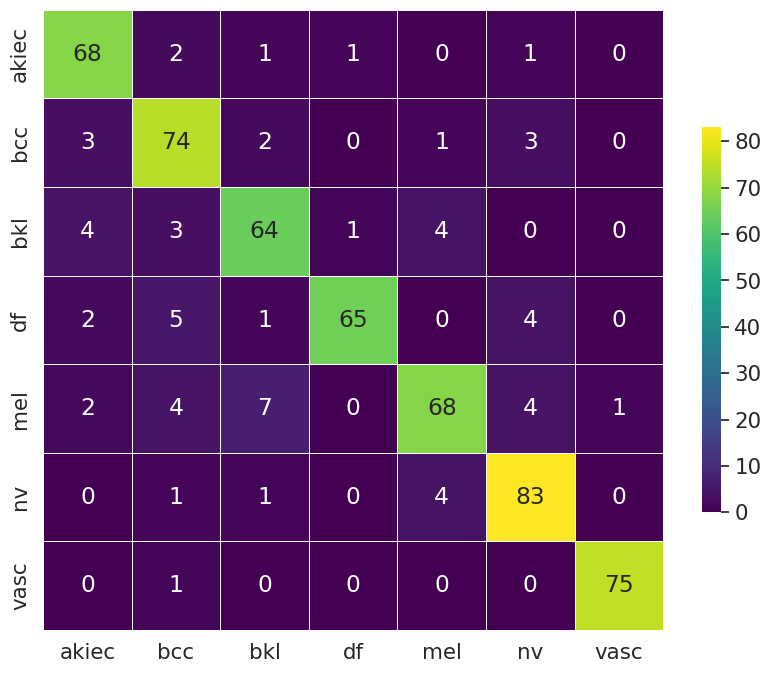

In [ ]:
metrics(X_test, y_test, model)

#Adding Gaussian Blur to the model prior to the base model

In [ ]:
S = 0.5 #@param {type:"slider", min:0, max:1, step:0.1}

# Build the full model by adding a gaussian blur to InceptionV3 
model = tf.keras.Sequential([
    # Input layer
    tf.keras.layers.Input(image_size),
    
    # batch Normalization layer
    tf.keras.layers.BatchNormalization(),

    # Gaussian Blur
    tf.keras.layers.GaussianNoise(S),
    
    base_model,
    Dropout(0.5),
    Dense(128, activation="relu",kernel_regularizer=regularizers.l2(0.02)),
    Dropout(0.5),
    Dense(7, activation = 'softmax',kernel_regularizer=regularizers.l2(0.02))
])

# Compile the model with an Adam optimizer and cross-entropy loss function
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_95 (Bat  (None, 128, 128, 3)      12        
 chNormalization)                                                
                                                                 
 gaussian_noise (GaussianNoi  (None, 128, 128, 3)      0         
 se)                                                             
                                                                 
 inception_v3 (Functional)   (None, 2048)              21802784  
                                                                 
 dropout_2 (Dropout)         (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 128)               262272    
                                                                 
 dropout_3 (Dropout)         (None, 128)              

In [ ]:
# Train the model on the training set
hist = model.fit(X_train, y_train, batch_size=20, epochs=35, validation_data=(X_val, y_val))

Epoch 1/35
101/101 [==============================] - 42s 65ms/step - loss: 5.8016 - accuracy: 0.7133 - val_loss: 8.1849 - val_accuracy: 0.2768
Epoch 2/35
101/101 [==============================] - 5s 52ms/step - loss: 4.9739 - accuracy: 0.8616 - val_loss: 6.2583 - val_accuracy: 0.5000
Epoch 3/35
101/101 [==============================] - 5s 51ms/step - loss: 4.4676 - accuracy: 0.8849 - val_loss: 5.8290 - val_accuracy: 0.4420
Epoch 4/35
101/101 [==============================] - 5s 50ms/step - loss: 4.0088 - accuracy: 0.9172 - val_loss: 6.8099 - val_accuracy: 0.3839
Epoch 5/35
101/101 [==============================] - 5s 52ms/step - loss: 3.5380 - accuracy: 0.9385 - val_loss: 5.4598 - val_accuracy: 0.4286
Epoch 6/35
101/101 [==============================] - 5s 52ms/step - loss: 3.2065 - accuracy: 0.9311 - val_loss: 5.2843 - val_accuracy: 0.4554
Epoch 7/35
101/101 [==============================] - 5s 50ms/step - loss: 2.8638 - accuracy: 0.9355 - val_loss: 4.5120 - val_accuracy: 0.473

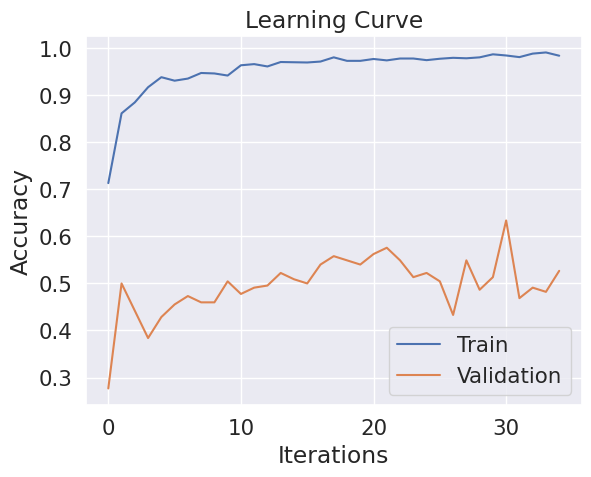

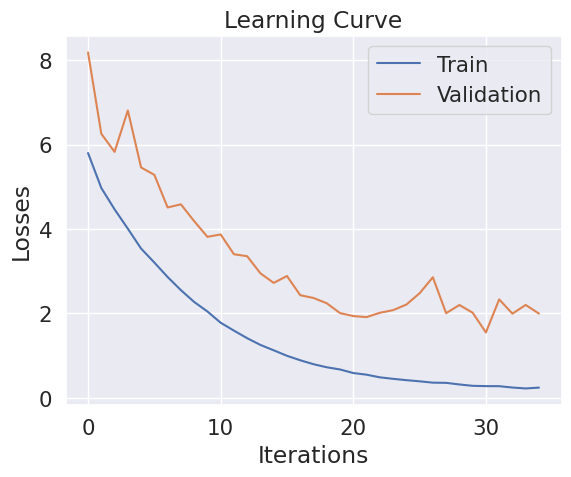

In [ ]:
plt.title("Learning Curve")
plt.plot(np.arange(35),hist.history.get('accuracy'), label="Train")
plt.plot(np.arange(35),hist.history.get('val_accuracy'), label="Validation")
plt.xlabel("Iterations")
plt.ylabel("Accuracy")
plt.legend(loc='best')
plt.show()

plt.title("Learning Curve")
plt.plot(np.arange(35),hist.history.get('loss'), label="Train")
plt.plot(np.arange(35),hist.history.get('val_loss'), label="Validation")
plt.xlabel("Iterations")
plt.ylabel("Losses")
plt.legend(loc='best')
plt.show()

18/18 [==============================] - 2s 9ms/step
              precision    recall  f1-score   support

       akiec       0.78      0.67      0.72        73
         bcc       0.90      0.22      0.35        83
         bkl       0.60      0.55      0.58        76
          df       1.00      0.26      0.41        77
         mel       0.73      0.35      0.47        86
          nv       0.70      0.62      0.65        89
        vasc       0.28      1.00      0.44        76

    accuracy                           0.52       560
   macro avg       0.71      0.52      0.52       560
weighted avg       0.72      0.52      0.52       560



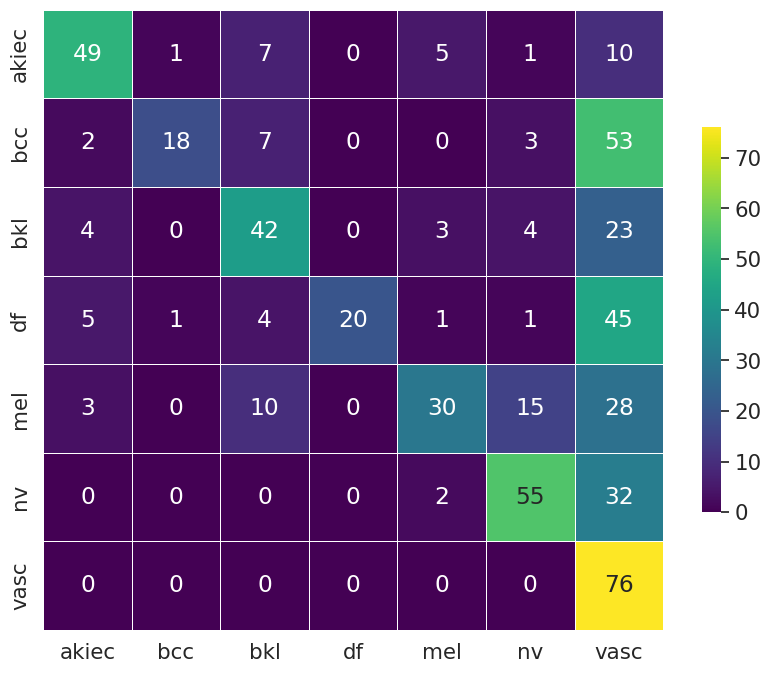

In [ ]:
metrics(X_test, y_test, model)

#WeightedRGBLayer

In [ ]:
# Create new weighted RGB image
import tensorflow.keras.backend as K

class WeightedRGBLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(WeightedRGBLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        # Define the trainable weights for the RGB channels
        self.r_weights = self.add_weight(name='r_weights', shape=(1,), initializer=initializers.Constant(value=0.5), trainable=True, constraint=tf.keras.constraints.NonNeg())
        self.g_weights = self.add_weight(name='g_weights', shape=(1,), initializer=initializers.Constant(value=0.5), trainable=True, constraint=tf.keras.constraints.NonNeg())
        self.b_weights = self.add_weight(name='b_weights', shape=(1,), initializer=initializers.Constant(value=0.5), trainable=True, constraint=tf.keras.constraints.NonNeg())

    def call(self, inputs):
        # Split the input image into its RGB channels
        r, g, b = tf.split(inputs, num_or_size_splits=3, axis=-1)

        # Scale the RGB channels by the trainable weights
        r_scaled = r * self.r_weights
        g_scaled = g * self.g_weights
        b_scaled = b * self.b_weights

        # Merge the scaled RGB channels into an image
        merged = tf.concat([r_scaled, g_scaled, b_scaled], axis=-1)
        merged = tf.abs(merged)
        return merged

    def compute_output_shape(self, input_shape):
        return input_shape

In [ ]:
class PlotLayerOutputCallback(tf.keras.callbacks.Callback):
    def __init__(self, layer_index, img, plot_freq=5):
        super(PlotLayerOutputCallback, self).__init__()
        self.layer_index = layer_index
        self.plot_freq = plot_freq
        self.img = img
        
    def on_epoch_end(self, epoch, logs=None):
        if (epoch+1) % self.plot_freq == 0:
            layer_output_func = tf.keras.backend.function([self.model.layers[0].input],
                                                           [self.model.layers[self.layer_index].output])
            layer_output = layer_output_func(self.img)[0]
            plt.imshow(layer_output[0])
            plt.axis('off')
            plt.show()
            rgb_weights = self.model.layers[2].get_weights()
            print("\nTrained RGB weights:\n")
            print(rgb_weights)

plot_callback = PlotLayerOutputCallback(layer_index = 0, plot_freq = 7, img = X_train[40:42])

In [ ]:
model = tf.keras.models.Sequential([
    # Input layer  
    tf.keras.layers.Input(image_size),
    
    # RGB regenerate layer
    tf.keras.layers.BatchNormalization(),

    # Gaussian Blur
    tf.keras.layers.GaussianNoise(S),

    # RGB regenerate layer
    WeightedRGBLayer(),
    
    # batch Normalization layer
    tf.keras.layers.BatchNormalization(),

    base_model,
    Dropout(0.5),
    Dense(128, activation="relu",kernel_regularizer=regularizers.l2(0.02)),
    Dropout(0.5),
    Dense(7, activation = 'softmax',kernel_regularizer=regularizers.l2(0.02))
])

# Compile the model with an Adam optimizer and cross-entropy loss function
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_96 (Bat  (None, 128, 128, 3)      12        
 chNormalization)                                                
                                                                 
 gaussian_noise_1 (GaussianN  (None, 128, 128, 3)      0         
 oise)                                                           
                                                                 
 weighted_rgb_layer (Weighte  (None, 128, 128, 3)      3         
 dRGBLayer)                                                      
                                                                 
 batch_normalization_97 (Bat  (None, 128, 128, 3)      12        
 chNormalization)                                                
                                                                 
 inception_v3 (Functional)   (None, 2048)             

Epoch 1/35
101/101 [==============================] - 43s 66ms/step - loss: 6.7321 - accuracy: 0.3477 - val_loss: 8.7247 - val_accuracy: 0.1384
Epoch 2/35
101/101 [==============================] - 5s 53ms/step - loss: 5.7376 - accuracy: 0.6260 - val_loss: 7.3631 - val_accuracy: 0.2545
Epoch 3/35
101/101 [==============================] - 5s 53ms/step - loss: 5.1226 - accuracy: 0.7416 - val_loss: 7.4786 - val_accuracy: 0.3348
Epoch 4/35
101/101 [==============================] - 5s 52ms/step - loss: 4.6179 - accuracy: 0.8239 - val_loss: 6.1648 - val_accuracy: 0.4330
Epoch 5/35
101/101 [==============================] - 5s 53ms/step - loss: 4.2031 - accuracy: 0.8512 - val_loss: 5.2863 - val_accuracy: 0.5491
Epoch 6/35
101/101 [==============================] - 5s 53ms/step - loss: 3.7926 - accuracy: 0.8924 - val_loss: 5.0190 - val_accuracy: 0.5491
Epoch 7/35
101/101 [==============================] - ETA: 0s - loss: 3.4658 - accuracy: 0.9058

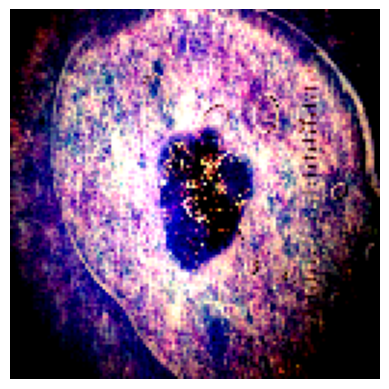


Trained RGB weights:

[array([0.49537045], dtype=float32), array([0.50256735], dtype=float32), array([0.5036481], dtype=float32)]
101/101 [==============================] - 5s 54ms/step - loss: 3.4658 - accuracy: 0.9058 - val_loss: 4.7771 - val_accuracy: 0.5223
Epoch 8/35
101/101 [==============================] - 5s 53ms/step - loss: 3.1564 - accuracy: 0.9077 - val_loss: 4.4181 - val_accuracy: 0.5848
Epoch 9/35
101/101 [==============================] - 5s 53ms/step - loss: 2.8213 - accuracy: 0.9385 - val_loss: 4.4397 - val_accuracy: 0.5312
Epoch 10/35
101/101 [==============================] - 5s 52ms/step - loss: 2.5832 - accuracy: 0.9355 - val_loss: 4.5715 - val_accuracy: 0.4911
Epoch 11/35
101/101 [==============================] - 5s 53ms/step - loss: 2.3553 - accuracy: 0.9385 - val_loss: 4.1376 - val_accuracy: 0.5402
Epoch 12/35
101/101 [==============================] - 5s 54ms/step - loss: 2.1013 - accuracy: 0.9499 - val_loss: 3.6844 - val_accuracy: 0.5848
Epoch 13/35
101/101

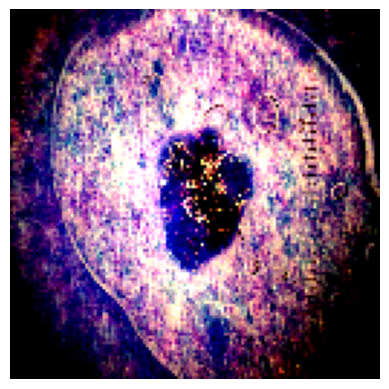


Trained RGB weights:

[array([0.49443907], dtype=float32), array([0.5028051], dtype=float32), array([0.50522625], dtype=float32)]
101/101 [==============================] - 6s 55ms/step - loss: 1.7049 - accuracy: 0.9608 - val_loss: 3.2691 - val_accuracy: 0.6205
Epoch 15/35
101/101 [==============================] - 5s 54ms/step - loss: 1.5622 - accuracy: 0.9549 - val_loss: 2.8804 - val_accuracy: 0.6518
Epoch 16/35
101/101 [==============================] - 5s 53ms/step - loss: 1.3798 - accuracy: 0.9648 - val_loss: 2.7444 - val_accuracy: 0.6295
Epoch 17/35
101/101 [==============================] - 5s 53ms/step - loss: 1.2787 - accuracy: 0.9593 - val_loss: 2.4872 - val_accuracy: 0.6295
Epoch 18/35
101/101 [==============================] - 5s 54ms/step - loss: 1.1468 - accuracy: 0.9568 - val_loss: 2.3825 - val_accuracy: 0.6473
Epoch 19/35
101/101 [==============================] - 5s 54ms/step - loss: 1.0153 - accuracy: 0.9697 - val_loss: 2.1443 - val_accuracy: 0.6652
Epoch 20/35
101/1

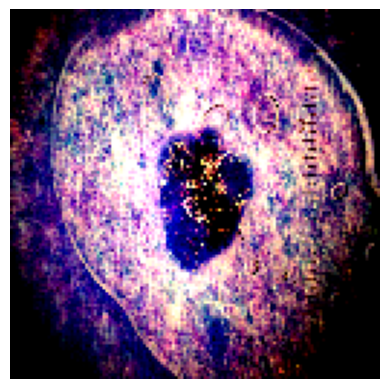


Trained RGB weights:

[array([0.4960513], dtype=float32), array([0.5007215], dtype=float32), array([0.50563157], dtype=float32)]
101/101 [==============================] - 6s 56ms/step - loss: 0.8071 - accuracy: 0.9782 - val_loss: 1.9170 - val_accuracy: 0.6696
Epoch 22/35
101/101 [==============================] - 5s 54ms/step - loss: 0.7307 - accuracy: 0.9787 - val_loss: 1.9040 - val_accuracy: 0.6652
Epoch 23/35
101/101 [==============================] - 5s 54ms/step - loss: 0.6798 - accuracy: 0.9752 - val_loss: 1.8697 - val_accuracy: 0.6473
Epoch 24/35
101/101 [==============================] - 5s 53ms/step - loss: 0.6086 - accuracy: 0.9802 - val_loss: 1.8107 - val_accuracy: 0.6562
Epoch 25/35
101/101 [==============================] - 6s 55ms/step - loss: 0.5267 - accuracy: 0.9856 - val_loss: 1.7366 - val_accuracy: 0.6429
Epoch 26/35
101/101 [==============================] - 5s 53ms/step - loss: 0.4869 - accuracy: 0.9871 - val_loss: 1.5689 - val_accuracy: 0.6741
Epoch 27/35
101/10

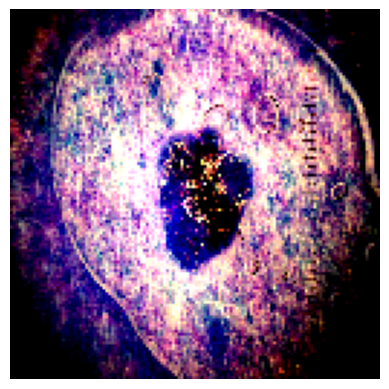


Trained RGB weights:

[array([0.49610114], dtype=float32), array([0.49867293], dtype=float32), array([0.50828797], dtype=float32)]
101/101 [==============================] - 6s 56ms/step - loss: 0.4110 - accuracy: 0.9851 - val_loss: 1.4442 - val_accuracy: 0.7232
Epoch 29/35
101/101 [==============================] - 5s 53ms/step - loss: 0.4063 - accuracy: 0.9762 - val_loss: 1.4145 - val_accuracy: 0.7009
Epoch 30/35
101/101 [==============================] - 5s 53ms/step - loss: 0.3589 - accuracy: 0.9816 - val_loss: 1.4191 - val_accuracy: 0.7098
Epoch 31/35
101/101 [==============================] - 5s 54ms/step - loss: 0.3333 - accuracy: 0.9821 - val_loss: 1.2352 - val_accuracy: 0.7054
Epoch 32/35
101/101 [==============================] - 5s 53ms/step - loss: 0.3185 - accuracy: 0.9836 - val_loss: 1.3860 - val_accuracy: 0.6786
Epoch 33/35
101/101 [==============================] - 5s 53ms/step - loss: 0.2856 - accuracy: 0.9876 - val_loss: 1.4236 - val_accuracy: 0.6607
Epoch 34/35
101/

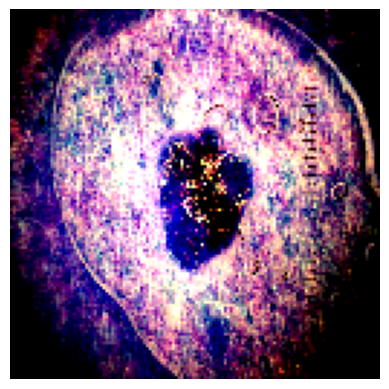


Trained RGB weights:

[array([0.4965653], dtype=float32), array([0.49916708], dtype=float32), array([0.5070707], dtype=float32)]
101/101 [==============================] - 6s 55ms/step - loss: 0.2839 - accuracy: 0.9792 - val_loss: 0.9578 - val_accuracy: 0.7857


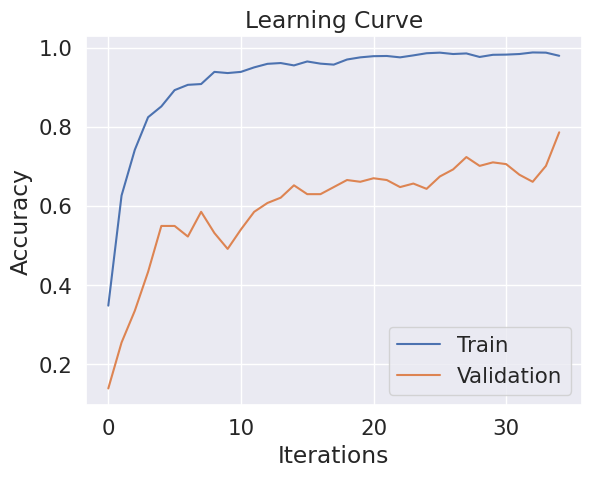

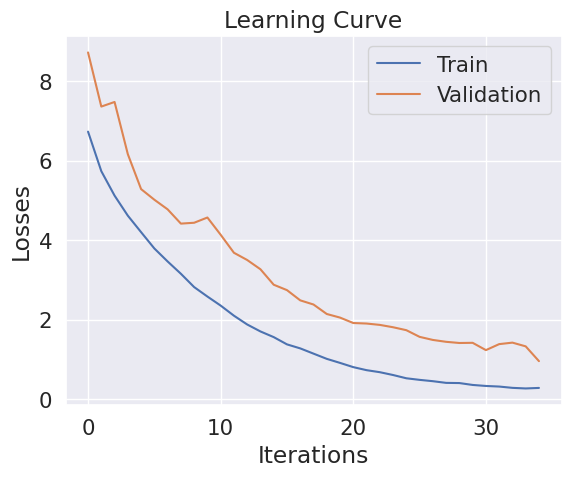

In [ ]:
# Train model with callback
hist = model.fit(X_train, y_train, batch_size=20, epochs=35, validation_data=(X_val, y_val), callbacks=[plot_callback])

plt.title("Learning Curve")
plt.plot(np.arange(35),hist.history.get('accuracy'), label="Train")
plt.plot(np.arange(35),hist.history.get('val_accuracy'), label="Validation")
plt.xlabel("Iterations")
plt.ylabel("Accuracy")
plt.legend(loc='best')
plt.show()

plt.title("Learning Curve")
plt.plot(np.arange(35),hist.history.get('loss'), label="Train")
plt.plot(np.arange(35),hist.history.get('val_loss'), label="Validation")
plt.xlabel("Iterations")
plt.ylabel("Losses")
plt.legend(loc='best')
plt.show()

18/18 [==============================] - 1s 8ms/step
              precision    recall  f1-score   support

       akiec       0.85      0.82      0.83        73
         bcc       0.95      0.67      0.79        83
         bkl       0.91      0.66      0.76        76
          df       0.98      0.53      0.69        77
         mel       0.68      0.79      0.73        86
          nv       0.59      0.87      0.70        89
        vasc       0.73      0.99      0.84        76

    accuracy                           0.76       560
   macro avg       0.81      0.76      0.76       560
weighted avg       0.81      0.76      0.76       560



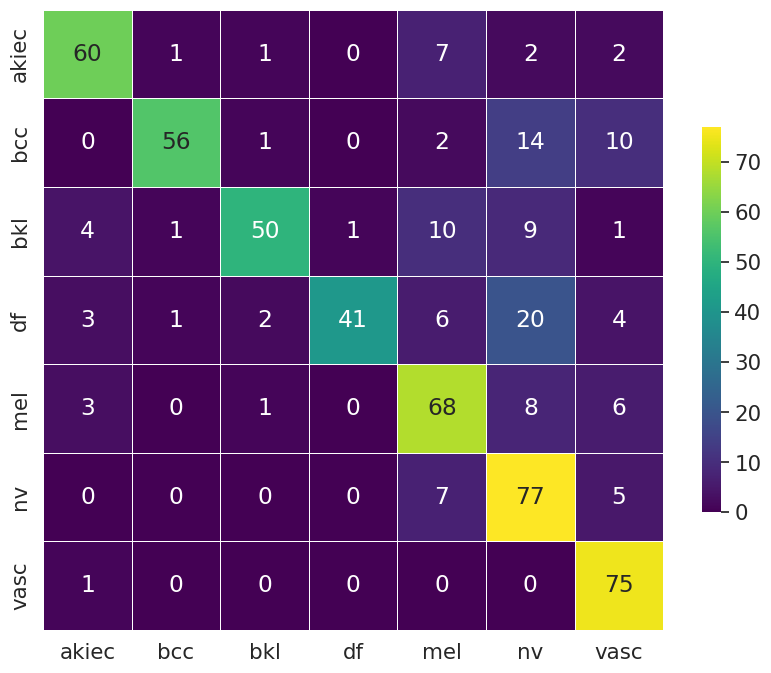

In [ ]:
metrics(X_test, y_test, model)